In [1]:
import torch
from diffusers.models import AutoencoderKL
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae.eval()

def preprocess_image(img_path):
  image = Image.open(img_path).convert("RGB")
  transform = transforms.Compose([
      transforms.Resize((512,512)),
      transforms.ToTensor(),
      transforms.Normalize([0.5],[0.5])
  ])
  return transform(image).unsqueeze(0).to(device)

def encode_image(img_tensor):
  with torch.no_grad():
    latent_dist = vae.encode(img_tensor)
    z = latent_dist.latent_dist.sample()
    return z * vae.config.scaling_factor

def apply_random_matrix(z):
    B, C, H, W = z.shape
    z_flat = z.view(B, C, -1)

    A = torch.linalg.qr(torch.randn(C, C).to(device)).Q
    z_transformed = torch.matmul(A, z_flat)
    return z_transformed.view(B, C, H, W)

def decode_latent(z):
    with torch.no_grad():
        return vae.decode(z / vae.config.scaling_factor).sample

def show_images(original, transformed):
    def to_pil(tensor_img):
        img = tensor_img.squeeze().cpu()
        img = (img * 0.5 + 0.5).clamp(0, 1)
        return transforms.ToPILImage()(img)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(to_pil(original))
    axs[0].axis("off")

    axs[1].imshow(to_pil(transformed))
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

def show_image(image):
    def to_pil(tensor_img):
        img = tensor_img.squeeze().cpu()
        img = (img * 0.5 + 0.5).clamp(0, 1)
        return transforms.ToPILImage()(img)

    plt.figure(figsize=(4, 4))
    plt.imshow(to_pil(image))
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

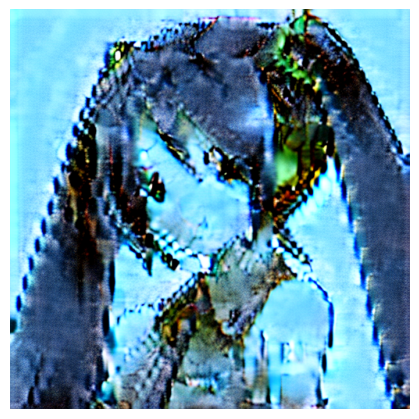

In [6]:
img_tensor = preprocess_image("miku.jpg")
z = encode_image(img_tensor)
z_tr = apply_random_matrix(z)
img_out = decode_latent(z_tr)

show_image(img_out)

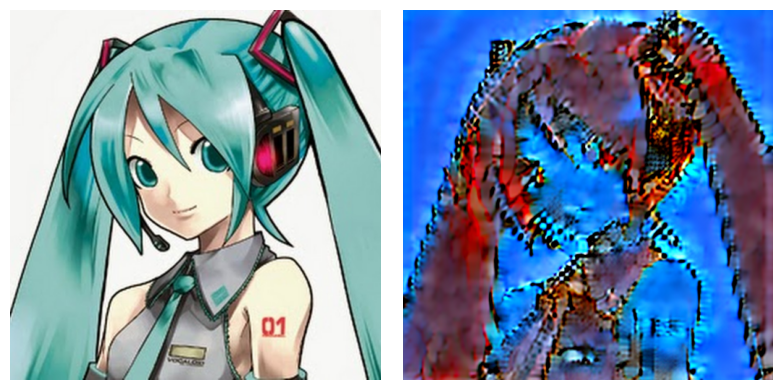

In [5]:
img_tensor = preprocess_image("miku.jpg")
z = encode_image(img_tensor)
z_tr = apply_random_matrix(z)
img_out = decode_latent(z_tr)

show_images(img_tensor, img_out)